In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

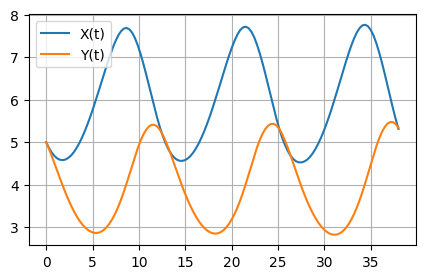

In [3]:
from scipy.integrate import solve_ivp

# We fix variables for clarity.
T = 38
alpha, beta, delta, gamma = 0.4, 0.1, 0.1, 0.6
x0, y0 = 5.0, 5.0

def lotka_volterra(t, u, alpha, beta, delta, gamma):
            x, y = u
            dx_dt = alpha * x - beta * x * y
            dy_dt = delta * x * y - gamma * y
            return [dx_dt, dy_dt]

t = torch.linspace(0, T, 128)
solution = solve_ivp(lotka_volterra, 
                        (0, T),
                        [x0, y0],
                        args=(alpha, beta, delta, gamma), 
                        t_eval=t)
x = solution.y[0]
y = solution.y[1]

fig = plt.figure(figsize=(5, 3))
plt.plot(t, x, label = 'X(t)')
plt.plot(t, y, label = 'Y(t)')
plt.grid()
plt.legend()
plt.show()

Our neural network for this task will have one input and two outputs.

In [4]:
from pinns.samplers import ConstantSampler, RandomRectangularSampler

constraints_sampler = ConstantSampler((
    torch.tensor([[0.]]),
    torch.tensor([x0, y0])
))

domain = {'t': [0, T]}
collocation_sampler = RandomRectangularSampler(domain, 2048, return_dict=False)

test_points_sampler = ConstantSampler((
    t.view(-1, 1), 
    torch.tensor([x, y]).T
    ))

In [5]:
from pinns.derivatives import Derivative

d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    # alpha = 0.4, beta = 0.1, delta = 0.1, gamma = 0.6
    ):
    
    def init_loss(u0, t0):
        return torch.mean(torch.square(u0 - cstr_vals))

    def ode_loss(u, t):
        x = u[:, [0]]
        y = u[:, [1]]
        
        dX = d(x, t)
        dY = d(y, t)
        
        LdX = torch.mean(torch.square(dX - alpha * x + beta * x * y))
        LdY = torch.mean(torch.square(dY - delta * x * y + gamma * y))
        
        return LdX, LdY
    
    return init_loss(cstr_pred, cstr_pts), *ode_loss(coll_pred, coll_pts)

In [6]:
ip_pts, ip_vals = test_points_sampler()
dists = ip_pts[:,0]

In [7]:
from pinns import Trainer
from pinns.models import FF
from pinns.activations import Sin
from pinns.optimizers import Adam
from pinns.metrics import rmse

pinn = FF([1] + [64]*4 + [2], activ=nn.Tanh(), biases=True)
pinn.init(nn.init.kaiming_normal_)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2, 0.2],    # Coefficients are very important.
)

num_iters = 8000

errors = []
def save_error():
    if trainer.iter == 0 or (trainer.iter + 1) % 25 == 0:
        preds = pinn(ip_pts).detach()
        error = (preds - ip_vals).abs().mean(dim=1).flatten()
        errors.append(error)

trainer.train(
    num_iters=num_iters,
    optimizers=[(0, adam)],
    validate_every=1,
    metrics = [rmse],
    test_sampler = test_points_sampler,
    training_start_callbacks = [save_error],
    epoch_end_callbacks=[save_error],
    )

Model has {'total': 12738, 'trainable': 12738} trainable parameters.


  0%|          | 0/8000 [00:00<?, ?it/s]

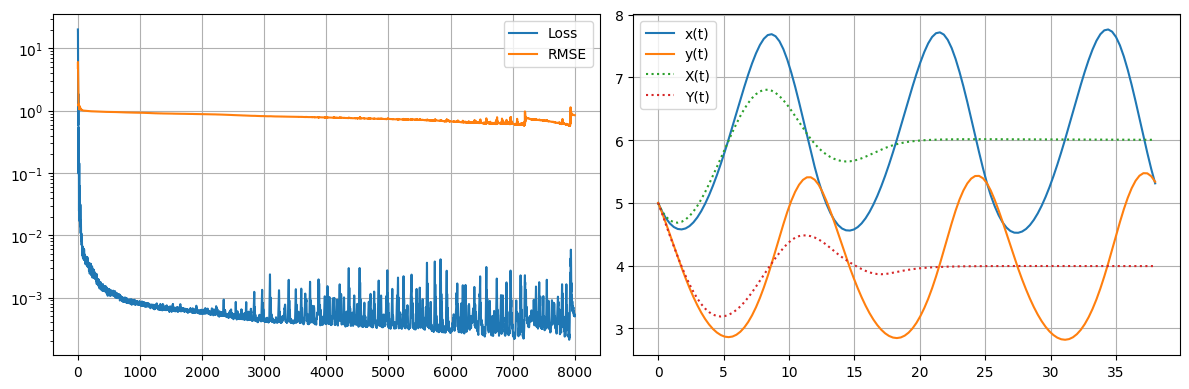

In [8]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(trainer.loss_history, label='Loss')
axs[0].plot(range(0, trainer.iter + 1, 1), trainer.error_history, label='RMSE')
axs[0].grid()
axs[0].set_yscale('log')
axs[0].legend()

preds = pinn.predict(t.reshape(-1, 1))
axs[1].plot(t, x, label = 'x(t)')
axs[1].plot(t, y, label = 'y(t)')
axs[1].plot(t, preds[:,0].detach(), label='X(t)', linestyle=':')
axs[1].plot(t, preds[:,1].detach(), label='Y(t)', linestyle=':')
axs[1].grid()
axs[1].legend()

plt.tight_layout()
plt.show()

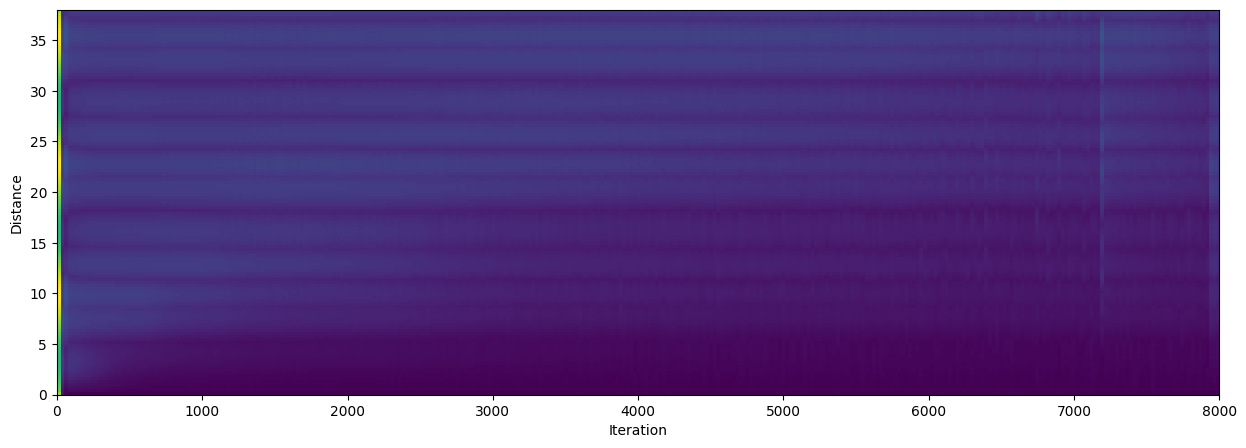

In [9]:
fig = plt.figure(figsize=(15, 5))

stacked_errors = torch.vstack([
    dists, *errors
]).T.numpy()
sorted_errors = stacked_errors[stacked_errors[:, 0].argsort()]

plt.imshow(sorted_errors[:,1:], aspect='auto', origin='lower', extent=[0, trainer.iter, 0, dists.max()])

plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.show()

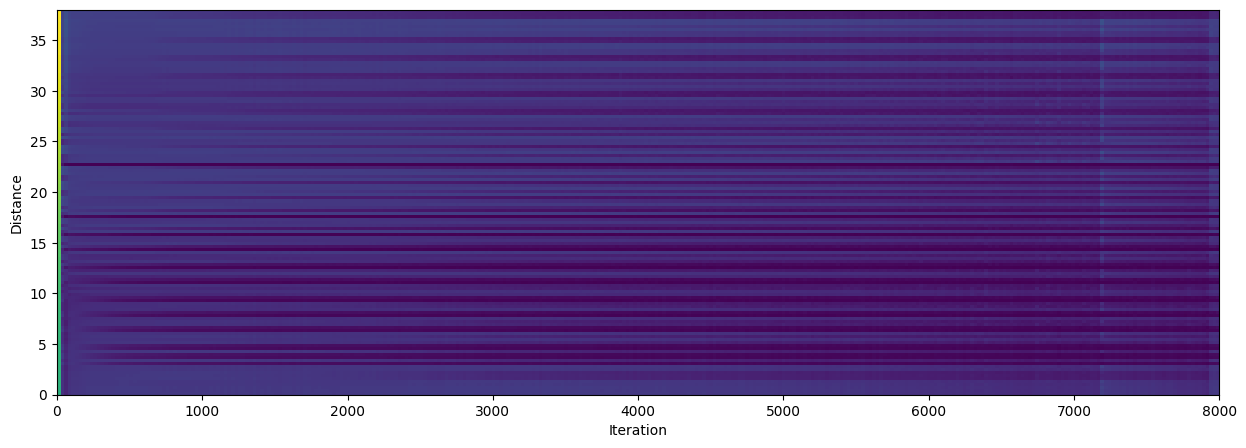

In [10]:
fig = plt.figure(figsize=(15, 5))

stacked_errors = torch.vstack([
    dists, *errors
]).T.numpy()
sorted_errors = stacked_errors[stacked_errors[:, 1].argsort()]

plt.imshow(sorted_errors[:,1:], aspect='auto', origin='lower', extent=[0, trainer.iter, 0, dists.max()])

plt.xlabel('Iteration')
plt.ylabel('Distance')
plt.show()